In [2]:
import os
import sys
import csv
import h5py
import argparse
import numpy as np
from collections import Counter, defaultdict

# 3rd party imports
from sklearn import manifold
from keras.models import Model
from keras import backend as K
from IPython.display import Image

# ML4CVD Imports
from ml4cvd.defines import TENSOR_EXT
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import train_shallow_model, train_multimodal_multitask, test_multimodal_multitask
from ml4cvd.models import make_multimodal_to_multilabel_model, train_model_from_generators, make_hidden_layer_model
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [3]:
latent_file = '/home/sam/ml/trained_models/mri_systole_diastole_8_volumes/hidden_inference_mri_systole_diastole_8_volumes.tsv'


latent2list = defaultdict(list)
tensor_path_prefix = '/mnt/disks/pix-size-tensors/2019-04-29/'
with open(latent_file, 'r') as my_tsv:
    lol = list(csv.reader(my_tsv, delimiter='\t'))
    header = lol[0]
for row in lol[1:]:
    for i in range(len(row)):
        val = float(row[i])
        if i > 0 and val != 0.0:
            latent2list[header[i]].append(val)

[print(k,latent2list[k][:10]) for k in latent2list]


latent_0 [-5.751032829284668, -4.325015544891357, -5.692793846130371, -4.4530229568481445, -2.4670448303222656, -2.061826705932617, -4.396632671356201, -2.7233011722564697, -5.7287278175354, -5.312638759613037]
latent_1 [6.209779262542725, 3.736400842666626, 7.107391834259033, 4.471875190734863, 0.8335965275764465, -0.1546493023633957, 3.393573522567749, 0.4318663477897644, 6.776533126831055, 6.0485615730285645]
latent_2 [-3.9074606895446777, -4.571091175079346, -2.4019062519073486, -3.8043723106384277, -4.876399993896484, -5.5783843994140625, -5.324101448059082, -6.184311866760254, -2.958256721496582, -3.2122178077697754]
latent_3 [2.9749739170074463, 1.9087225198745728, 3.2666823863983154, 2.1685590744018555, 0.633842408657074, 0.2273515909910202, 1.7983849048614502, 0.5282647013664246, 3.1646504402160645, 2.846257209777832]
latent_4 [-1.8872697353363037, -0.7837058901786804, -1.3384218215942383, -0.14652913808822632, 0.41096192598342896, 1.0253009796142578, -0.6644436717033386, 0.54

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

latent_0 pearson with latent_1 is -0.991
latent_0 pearson with latent_2 is -0.858
latent_0 pearson with latent_3 is -0.994
latent_0 pearson with latent_4 is 0.938
latent_0 pearson with latent_5 is -0.948
latent_0 pearson with latent_6 is -0.916
latent_0 pearson with latent_7 is 0.998
latent_0 pearson with latent_8 is -0.850
latent_0 pearson with latent_9 is 0.999
latent_0 pearson with latent_10 is 0.961
latent_0 pearson with latent_11 is 0.964
latent_0 pearson with latent_12 is -0.600
latent_0 pearson with latent_13 is 0.885
latent_0 pearson with latent_14 is -0.836
latent_0 pearson with latent_15 is 0.984
latent_1 pearson with latent_0 is -0.991
latent_1 pearson with latent_2 is 0.919
latent_1 pearson with latent_3 is 1.000
latent_1 pearson with latent_4 is -0.923
latent_1 pearson with latent_5 is 0.923
latent_1 pearson with latent_6 is 0.960
latent_1 pearson with latent_7 is -0.986
latent_1 pearson with latent_8 is 0.879
latent_1 pearson with latent_9 is -0.984
latent_1 pearson with 

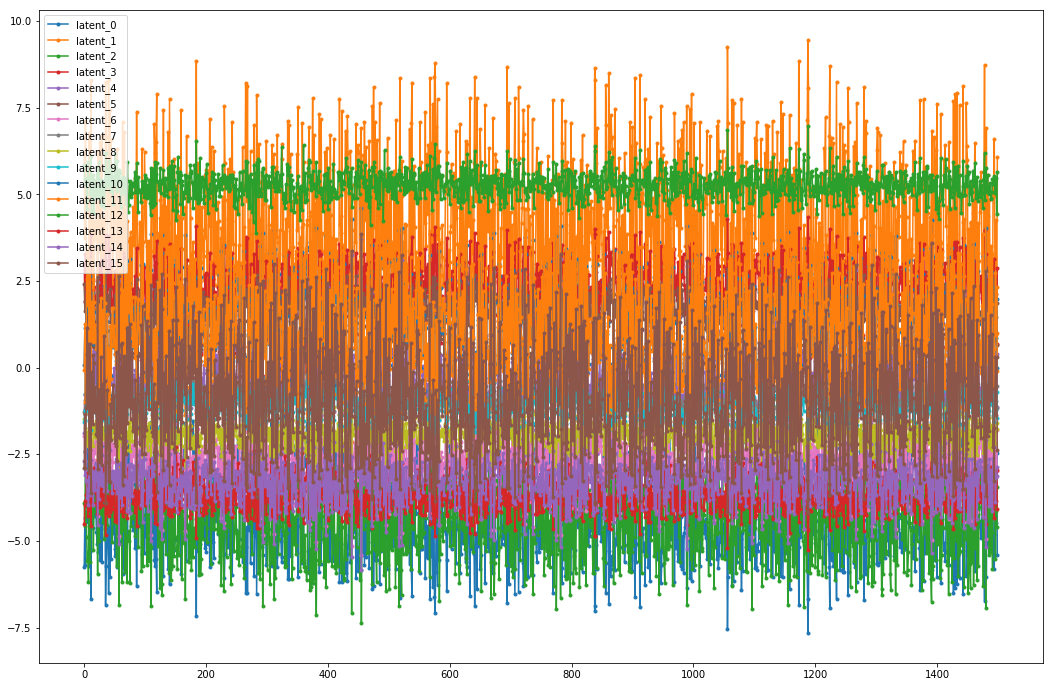

In [4]:
plt.figure(figsize=(18, 12))
for k in latent2list:
    plt.plot(latent2list[k][:1500], label=f"{k}", marker='.')
    for j in latent2list:
        if j != k and len(latent2list[k][:1500]) == len(latent2list[j][:1500]):
            pearson = np.corrcoef(latent2list[k][:1500], latent2list[j][:1500])[1, 0]  # corrcoef returns full covariance matrix
            print(f'{k} pearson with {j} is {pearson:0.3f}')
plt.legend(loc="upper left")


In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_systole_diastole_weighted', 'mri_pixel_width', 'mri_pixel_height',
            '--output_tensors', 'mri_systole_diastole_segmented_weighted', 'end_systole_volume', 'end_diastole_volume',
                                 'ejection_fraction', 'lv_mass',
            '--batch_size', '4',
            '--pool_z', '1',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--u_connect',
            '--training_steps', '128',
            '--validation_steps', '6',
            '--test_steps', '6',
            '--model_file', '/home/sam/ml/trained_models/mri_systole_diastole_pixsize_unet_to_seg_volumes_mass_ef/mri_systole_diastole_pixsize_unet_to_seg_volumes_mass_ef.hd5',
            '--id', 'mri_systole_diastole_unet_lv_mass_diseases']
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)
model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps*16)

In [ ]:
gene2batch = {}
for g in gene2samples:
    gene_generator = TensorGenerator(args.batch_size, args.tensor_maps_in, args.tensor_maps_out, gene2samples[g], None, True)
    if g in gene_labels:
        gene2batch[g] = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out, gene_generator, args.test_steps) 

In [ ]:
for g in gene_labels:
    for k in test_data:
        test_data[k] = np.concatenate([test_data[k], gene2batch[g][0][k]])
    for k in test_labels:
        test_labels[k] = np.concatenate([test_labels[k], gene2batch[g][1][k]])    
    test_paths.extend(gene2batch[g][2])

In [ ]:
layer_name = 'embed'
d1 = model.get_layer(layer_name)
w1 = d1.get_weights()
for w in w1:
    print(w.shape)
embed_model = make_hidden_layer_model(model, args.tensor_maps_in, layer_name)
embed_model.summary()
print(list(test_data.keys()))
x_embed = embed_model.predict(test_data, batch_size=args.batch_size)
predictions = model.predict(test_data, batch_size=args.batch_size)

In [ ]:
categorical_labels = [ 'Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 'Handedness-chiralitylaterality_Righthanded_0_0']
continuous_labels = ['22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0']

label_dict = {k: np.zeros((len(test_paths))) for k in categorical_labels + continuous_labels + gene_labels}
for i, tp in enumerate(test_paths):
    hd5 = h5py.File(tp, 'r')
    #print(list(hd5['continuous'].keys()))
    for k in categorical_labels:
        if k in hd5['categorical']:
            label_dict[k][i] = 1
        elif k in hd5 and hd5[k][0] == 1:
            label_dict[k][i] = 1
    for mk in continuous_labels:
        for k in mk.split('|'):
            if k in hd5['continuous']:
                label_dict[mk][i] = hd5['continuous'][k][0]
    for k in gene_labels:
        if tp in samples2genes and samples2genes[tp] == k:
            label_dict[k][i] = 1
            
print(list(label_dict.keys()))
print(len(test_paths))

In [ ]:
n_components = 2
max_rows = 30
(fig, subplots) = plt.subplots(min(max_rows, len(label_dict)), 3, figsize=(20, max_rows*4))
perplexities = [18, 25, 40]

p2y = {}
for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity, n_iter=5000)
    p2y[perplexity] = tsne.fit_transform(x_embed)

j = -1
for k in label_dict:
    j += 1
    if j == max_rows:
        break
    if k in categorical_labels+gene_labels:
        red = label_dict[k] == 1.0
        green = label_dict[k] != 1.0
    elif k in continuous_labels:
        colors = label_dict[k]      
        
    print('process key:', k)
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        ax.set_title(k+", Perplexity=%d" % perplexity)
        if k in categorical_labels+gene_labels:
            ax.scatter(p2y[perplexity][green, 0], p2y[perplexity][green, 1], c="g")
            ax.scatter(p2y[perplexity][red, 0], p2y[perplexity][red, 1], c="r")
            ax.legend(['no_'+k, k], loc='lower left')
        elif k in continuous_labels:
            points = ax.scatter(p2y[perplexity][:, 0], p2y[perplexity][:, 1], c=colors, cmap='jet') 
            if i == len(perplexities)-1:
                fig.colorbar(points, ax=ax)
                
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
plt.show()
